Preparando os dados da bbox:

In [78]:
%pip install ultralytics -q
import os
import random
from PIL import Image
import shutil
from ultralytics import YOLO

# Define dataset root
original_dataset_path = 'data/'
yolo_dataset_path = 'yolo_dataset'

Note: you may need to restart the kernel to use updated packages.


In [16]:
yolo_dirs = [
    os.path.join(yolo_dataset_path, 'images', 'train'),
    os.path.join(yolo_dataset_path, 'images', 'val'),
    os.path.join(yolo_dataset_path, 'labels', 'train'),
    os.path.join(yolo_dataset_path, 'labels', 'val')
]

for yolo_dir in yolo_dirs:
    os.makedirs(yolo_dir, exist_ok=True)

jpeg_images_dir = os.path.join(original_dataset_path, 'VOC2012_train_val', 'JPEGImages')
annotations_dir = os.path.join(original_dataset_path, 'VOC2012_train_val', 'Annotations')
if not os.path.exists(jpeg_images_dir) or not os.path.exists(annotations_dir):
    raise FileNotFoundError(f"The directory {jpeg_images_dir} or {annotations_dir} does not exist. Please verify the dataset path.")
image_filenames = os.listdir(jpeg_images_dir)
image_ids = [os.path.splitext(filename)[0] for filename in image_filenames if filename.endswith('.jpg')]

random.seed(42)
random.shuffle(image_ids)
split_index = int(0.8 * len(image_ids)) #Spliting the dataset 80% for training, 20% for validation
train_ids = image_ids[:split_index] #taking the first 80% pictures
val_ids = image_ids[split_index:]

In [17]:
import xml.etree.ElementTree as ET 
#this fucntion converts PASCAL_VOC annotations to YOLO format
def create_yolo_annotation(xml_file_path, yolo_label_path, label_dict):
    tree = ET.parse(xml_file_path)
    root = tree.getroot()
    annotations = [] #list that will store the converted YOLO annotations.

    img_width = int(root.find('size/width').text)
    img_height = int(root.find('size/height').text)

    for obj in root.findall('object'):
        label = obj.find('name').text
        if label not in label_dict:
            continue
        label_idx = label_dict[label]
        bndbox = obj.find('bndbox')
        xmin = float(bndbox.find('xmin').text)
        ymin = float(bndbox.find('ymin').text)
        xmax = float(bndbox.find('xmax').text)
        ymax = float(bndbox.find('ymax').text)

        # this is YOLOv8 annotation format: label x_center y_center width height (normalized)
        x_center = ((xmin + xmax) / 2) / img_width
        y_center = ((ymin + ymax) / 2) / img_height
        width = (xmax - xmin) / img_width
        height = (ymax - ymin) / img_height

        annotations.append(f"{label_idx} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

    #annotations to the label file
    with open(yolo_label_path, 'w') as f:
        f.write("\n".join(annotations))

In [18]:
label_dict = {
    'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4,
    'bus': 5, 'car': 6, 'cat': 7, 'chair': 8, 'cow': 9,
    'diningtable': 10, 'dog': 11, 'horse': 12, 'motorbike': 13, 'person': 14,
    'pottedplant': 15, 'sheep': 16, 'sofa': 17, 'train': 18, 'tvmonitor': 19
}

for image_set, ids in [('train', train_ids), ('val', val_ids)]:
    for img_id in ids:
        img_src_path = os.path.join(jpeg_images_dir, f'{img_id}.jpg')
        label_dst_path = os.path.join(yolo_dataset_path, 'labels', image_set, f'{img_id}.txt')

        # Create the YOLO annotation file
        xml_file_path = os.path.join(annotations_dir, f'{img_id}.xml')
        if not os.path.exists(xml_file_path):
            print(f"Warning: Annotation {xml_file_path} not found, skipping.")
            continue
        create_yolo_annotation(xml_file_path, label_dst_path, label_dict)

        # Copy the image to the new YOLO dataset structure
        img_dst_path = os.path.join(yolo_dataset_path, 'images', image_set, f'{img_id}.jpg')
        shutil.copy(img_src_path, img_dst_path)

## Testando na YOLOv8

In [ ]:
yaml_content = f"""
train: images/train
val: images/val

nc: {len(label_dict)}
names: {list(label_dict.keys())}
"""

with open(os.path.join(yolo_dataset_path, 'data.yaml'), 'w') as f:
    f.write(yaml_content)

In [21]:
model = YOLO('yolov8n.pt')  # Use the YOLOv8 nano model

# Train the model
model.train(
    data=os.path.join(yolo_dataset_path, 'data.yaml'),  # Path to dataset config file
    epochs=2,  # Number of epochs
    imgsz=640,  # Image size
    batch=16,  # Batch size
    name='yolov8_test'  # Experiment name
)

Ultralytics 8.3.198 🚀 Python-3.11.9 torch-2.4.1+cu118 CUDA:0 (NVIDIA RTX A4000, 15977MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=2, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8_test3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True,

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7af14c1d2e10>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043

In [31]:
results = model.predict(source=os.path.join(yolo_dataset_path, 'images/val/'), save=True)  # Run inference on validation set

# Display predictions
for result in results:
    result.show()
    break


WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/3425 /home/livia/Documentos/Projetos/monitoria/yolo_dataset/images/val/2007_000042.jpg: 448x640 3 trains, 3.9ms
image 2/3425 /home/livia/Documentos/Projetos/monitoria/yolo_dataset/images/val/2007_000068.jpg: 480x640 (no detections), 36.3ms
image 3/3425 /home/livia/Documentos/Projetos/monitoria/yolo_dataset/images/val/2007_000323.jpg: 480x640 2 persons, 2.8ms
image 4/3425 /home/livia/Documentos/Projetos/monitoria/yolo_dataset/images/val/2007_000

In [75]:
max_conf = 0
best_result = None

for result in results:    
        if (result.boxes.conf.mean().item() > max_conf) and (result.boxes.conf.mean().item() < 0.98) and (result.boxes.conf.shape[0] > 2):
            max_conf = result.boxes.conf.mean().item()
            best_result = result

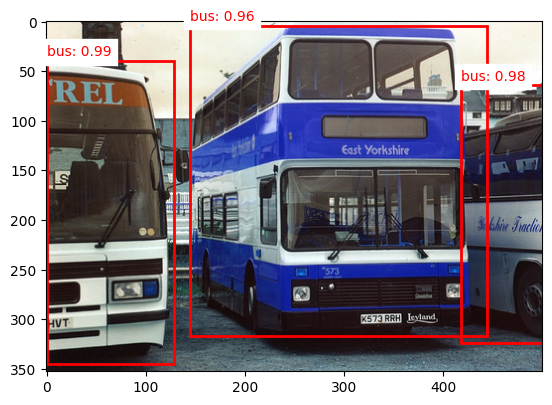

In [76]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

img = best_result.orig_img
boxes = best_result.boxes.xyxy.cpu().numpy()  # xyxy format
classe = best_result.boxes.cls
confianca = best_result.boxes.conf

fig, ax = plt.subplots(1)
ax.imshow(img)

for i, box in enumerate(boxes):
    x1, y1, x2, y2 = box[:4]
    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    # Add class and confidence
    class_idx = int(classe[i])
    class_name = best_result.names[class_idx] if hasattr(best_result, 'names') else str(class_idx)
    conf = float(confianca[i])
    ax.text(x1, y1 - 5, f'{class_name}: {conf:.2f}', color='red', fontsize=10, backgroundcolor='white')

plt.show()